In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import tensorflow as tf  
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir dataset

In [4]:
!cp "drive/My Drive/Data rn" dataset/ -r

In [5]:
classes = ["Tomatoes", "aubergines", "betterave",  "carottes", "concombre", "courgettes", 
           "navet", "oignon", "patates", "poivron"
           ]

In [6]:
len(classes)

10

In [7]:
!rm -rf "/content/dataset/Data rn/en plus" 

In [8]:
!rm -rf "/content/dataset/Data rn/feunouil"

In [9]:
!rm -rf "/content/dataset/Data rn/artichaut"

In [10]:
!rm -rf "/content/splitted-dataset"

In [11]:
!ls

dataset  drive	sample_data


In [ ]:
!ls dataset

'Data rn'


In [12]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import splitfolders # or import splitfolders
input_folder = "/content/dataset/Data rn"
output = "splitted-dataset" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .2, .1))

Copying files: 771 files [01:01, 12.54 files/s]


In [14]:
dataset_path = "splitted-dataset"

for class_name in classes:
  for folder in ["train", "test", "val"]:
    dir_path= os.path.join(dataset_path, folder, class_name)
    print(class_name, folder, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Tomatoes train 54
Tomatoes test 9
Tomatoes val 15
aubergines train 47
aubergines test 8
aubergines val 13
betterave train 56
betterave test 8
betterave val 16
carottes train 67
carottes test 11
carottes val 19
concombre train 53
concombre test 8
concombre val 15
courgettes train 37
courgettes test 6
courgettes val 10
navet train 57
navet test 9
navet val 16
oignon train 37
oignon test 7
oignon val 10
patates train 64
patates test 10
patates val 18
poivron train 63
poivron test 10
poivron val 18


## Image generation

In [33]:
train_image_generator=ImageDataGenerator(rescale=1./255,vertical_flip='true',
                                         zoom_range=0.2,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         fill_mode='nearest'                                         
                                         )
valid_image_generator=ImageDataGenerator(rescale=1./255)

In [34]:
BATCH_SIZE=16
IMG_SHAPE=128

In [39]:
train_data_gen=train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                         directory=os.path.join(dataset_path, "train"),
                                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                                         shuffle='True',
                                                         class_mode='categorical')
valid_data_gen=valid_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         directory=os.path.join(dataset_path, "val"),
                                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                                         class_mode='categorical')
test_dta_gen=valid_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         directory=os.path.join(dataset_path, "test"),
                                                         target_size=(224,224),
                                                         class_mode='categorical')

Found 535 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 86 images belonging to 10 classes.


In [18]:
num_train = 535
num_valid = 150

In [19]:
sample_training_images, _=next(train_data_gen)

In [20]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

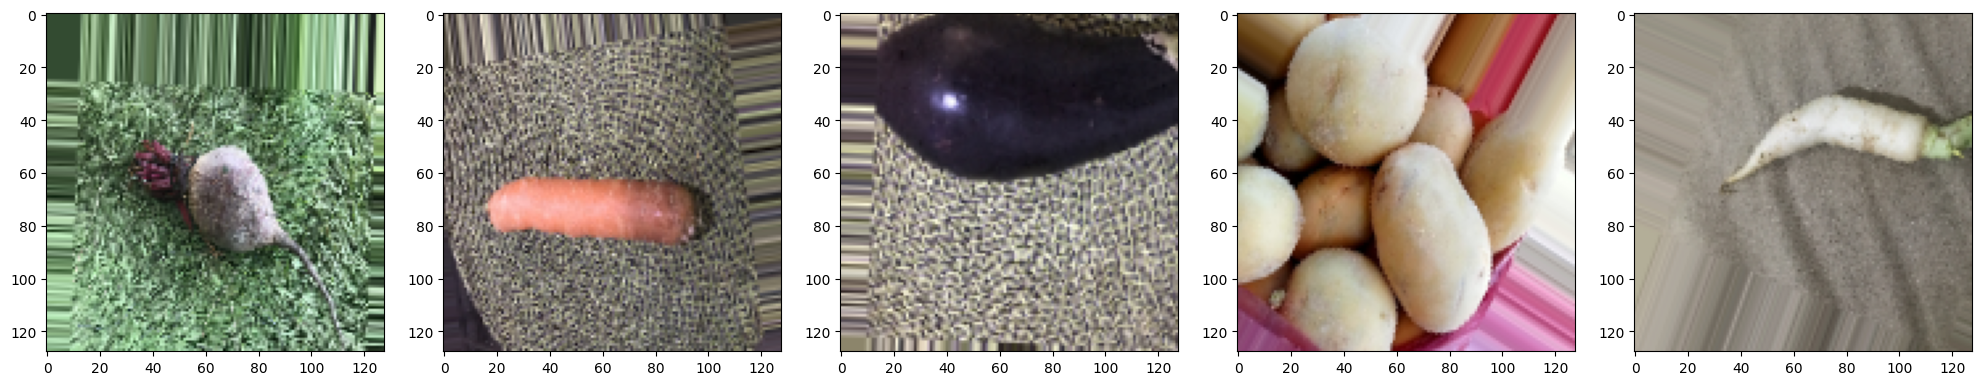

In [21]:
plotImages(sample_training_images[5:10])

# Model

# CNN

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224, 3)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=516, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [ ]:

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2 = 0.999, epsilon=1e-8)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"], )

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model1.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(train_data_gen,
          steps_per_epoch=len(train_data_gen),
          validation_data=valid_data_gen,
          validation_steps=len(valid_data_gen),
          epochs=100,
          batch_size=BATCH_SIZE, 
          verbose = 2,
          callbacks=[es, mc]
)

Epoch 1/100

Epoch 1: val_accuracy improved from 0.88000 to 0.89333, saving model to ./model1.h5
34/34 - 162s - loss: 0.4006 - accuracy: 0.8729 - val_loss: 0.3522 - val_accuracy: 0.8933 - 162s/epoch - 5s/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.89333 to 0.90000, saving model to ./model1.h5
34/34 - 155s - loss: 0.3728 - accuracy: 0.8972 - val_loss: 0.4006 - val_accuracy: 0.9000 - 155s/epoch - 5s/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.90000
34/34 - 154s - loss: 0.4465 - accuracy: 0.8748 - val_loss: 0.6077 - val_accuracy: 0.8067 - 154s/epoch - 5s/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.90000
34/34 - 156s - loss: 0.4120 - accuracy: 0.8748 - val_loss: 0.4799 - val_accuracy: 0.8133 - 156s/epoch - 5s/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.90000
34/34 - 152s - loss: 0.2893 - accuracy: 0.9065 - val_loss: 0.3683 - val_accuracy: 0.8800 - 152s/epoch - 4s/step
Epoch 6/100

Epoch 6: val_accuracy improved from 0.900

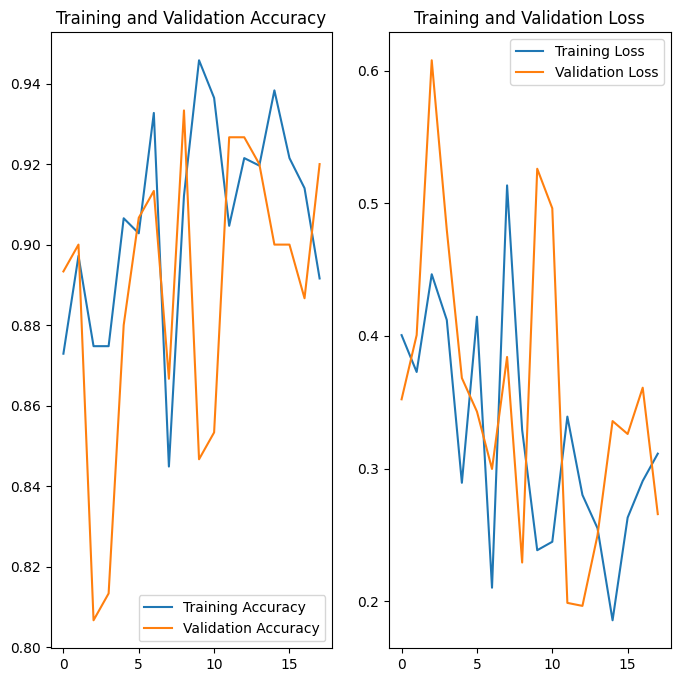

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(18)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [41]:
patch_size=4

In [42]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


##### generate patches 
class generate_patch(layers.Layer):
  def __init__(self, patch_size):
    super(generate_patch, self).__init__()
    self.patch_size = patch_size
    
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images=images, 
                                       sizes=[1, self.patch_size, self.patch_size, 1], 
                                       strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims]) #here shape is (batch_size, num_patches, patch_h*patch_w*c) 
    return patches


In [43]:
class PatchEncode_Embed(layers.Layer):
  '''
  2 steps happen here
  1. flatten the patches 
  2. Map to dim D; patch embeddings  
  '''
  def __init__(self, num_patches, projection_dim):
    super(PatchEncode_Embed, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim) # activation = linear
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim)
    
  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded
     


In [44]:
class generate_patch_conv(layers.Layer):
  '''
  this is an example to generate conv patches comparable with the image patches
  generated using tf extract image patches. This wasn't the original implementation, specially 
  the number of filters in the conv layer has nothing to do with patch size. It must be same as
  hidden dim (query/key dim) in relation to multi-head attention layer.       
  '''
  def __init__(self, patch_size):
    super(generate_patch_conv, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = layers.Conv2D(self.patch_size*self.patch_size*3, self.patch_size, self.patch_size, padding='valid')(images)

    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches  

class generate_patch_conv_orgPaper(layers.Layer):
  '''
  original implementation, 
  hidden size = query/key dim in multi head attention layer later. 
  '''
  def __init__(self, patch_size, hidden_size):
    super(generate_patch_conv_orgPaper, self).__init__()
    self.patch_size = patch_size
    self.hidden_size = hidden_size

  def call(self, images):
    patches = layers.Conv2D(self.hidden_size, self.patch_size, self.patch_size, padding='valid', name='Embedding')(images) 
    # kernels and strides = patch size
    # the weights of the convolutional layer will be learned. 
    rows_axis, cols_axis = (1, 2) # channels last images
    #if channels_last:
      #rows_axis, cols_axis = (2, 3) # for channels last
      # x = tf.transpose(patches, perm=[0, 2, 3, 1]) # do this for channels_first
    seq_len = (images.shape[rows_axis] // patch_size) * (images.shape[cols_axis] // patch_size)
    x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
    return x

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
  patches = layers.Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
  row_axis, col_axis = (1, 2) # channels last images
  seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
  x = tf.reshape(patches, [-1, seq_len, hidden_size])
  return x

In [45]:
class AddPositionEmbs(layers.Layer):
  """Adds (optionally learned) positional embeddings to the inputs."""

  def __init__(self, posemb_init=None, **kwargs):
    super().__init__(**kwargs)
    self.posemb_init = posemb_init
    #posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input') # used in original code

  def build(self, inputs_shape):
    pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
    self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

  def call(self, inputs, inputs_positions=None):
    # inputs.shape is (batch_size, seq_len, emb_dim).
    pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

    return inputs + pos_embedding

  def get_config(self):
        config = super(AddPositionEmbs, self).get_config()
        config.update({
            "pos_emb": self.posemb_init,
        })
        return config

In [46]:

def mlp_block_f(mlp_dim, inputs):
  x = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(inputs)
  x = layers.Dropout(rate=0.1)(x) # dropout rate is from original paper,
  x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
  x = layers.Dropout(rate=0.1)(x)
  return x

# class Encoder1Dblock(layers.Layer):
#   def __init__(self, num_heads, mlp_dim):
#     super(Encoder1Dblock, self).__init__()
#     self.num_heads = num_heads # number of heads in multi-head block
#     self.mlp_dim = mlp_dim
#   def call(self, inputs):
#     x = layers.LayerNormalization(dtype=self.dtype)(inputs)
#     x = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
#     x = layers.Add()([x, inputs]) # 1st residual part 
    
    # #### mlp block 
    # y = layers.LayerNormalization(dtype=self.dtype)(x)
    # y = mlp_block(mlp_dim=self.mlp_dim)(y)
    # y_1 = layers.Add()([y, x]) #2nd residual part 
    # return y_1


def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
  x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
  x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
  x = layers.Add()([x, inputs]) # 1st residual part 
  
  y = layers.LayerNormalization(dtype=x.dtype)(x)
  y = mlp_block_f(mlp_dim, y)
  y_1 = layers.Add()([y, x]) #2nd residual part 
  return y_1



In [47]:
def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
  x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
  x = layers.Dropout(rate=0.2)(x)
  for _ in range(num_layers):
    x = Encoder1Dblock_f(num_heads, mlp_dim, x)

  encoded = layers.LayerNormalization(name='encoder_norm')(x)
  return encoded




######################################
# hyperparameter section 
###################################### 
transformer_layers = 6
patch_size = 4
hidden_size = 128
num_heads = 4
mlp_dim = 128

######################################


rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

def build_ViT():
  inputs = layers.Input(shape=(128,128, 3))

  # rescale = rescale_layer(inputs)
  # generate patches with conv layer
  patches = generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs)

  ######################################
  # ready for the transformer blocks
  ######################################
  encoder_out = Encoder_f(transformer_layers, mlp_dim, num_heads, patches)  

  #####################################
  #  final part (mlp to classification)
  #####################################
  #encoder_out_rank = int(tf.experimental.numpy.ndim(encoder_out))
  im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)

  logits = layers.Dense(units=10, name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 

  final_model = tf.keras.Model(inputs = inputs, outputs = logits)
  return final_model



ViT_model = build_ViT()
ViT_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 128)  6272        ['input_2[0][0]']                
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (None, 1024, 128)    0           ['conv2d_1[0][0]']               
                                                                                                  
 posembed_input (AddPositionEmb  (None, 1024, 128)   131072      ['tf.reshape_1[0][0]']     

In [48]:
ViT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), 
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5 acc')]) 


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5, verbose=1)

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=10, verbose=0, 
                                      mode="auto", baseline=None,restore_best_weights=False)
mc = ModelCheckpoint('drive/My Drive/pfe/vit.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

ViT_Train = ViT_model.fit(train_data_gen, 
                        epochs = 120, 
                        validation_data=valid_data_gen, 
                        callbacks=[reduce_lr, es, mc], 
                        verbose=2,
                        batch_size=BATCH_SIZE, 
                        )

Epoch 1/120

Epoch 1: val_accuracy improved from -inf to 0.12000, saving model to drive/My Drive/pfe/vit.h5
34/34 - 1478s - loss: 2.3165 - accuracy: 0.1252 - top5 acc: 0.5514 - val_loss: 2.3024 - val_accuracy: 0.1200 - val_top5 acc: 0.5733 - lr: 0.0020 - 1478s/epoch - 43s/step
Epoch 2/120


KeyboardInterrupt: ignored

In [49]:
model = tf.keras.models.load_model('drive/My Drive/pfe/model1.h5')

In [50]:
loss, accuracy = model.evaluate(test_dta_gen, steps=len(test_dta_gen))
print('Test loss:', loss)
print('Test accuracy:', accuracy)

6/6 [==============================] - 37s 6s/step - loss: 0.2545 - accuracy: 0.9419
Test loss: 0.2545458674430847
Test accuracy: 0.9418604373931885
